Global Min/Max for 2014: -11.34%, 0.37%


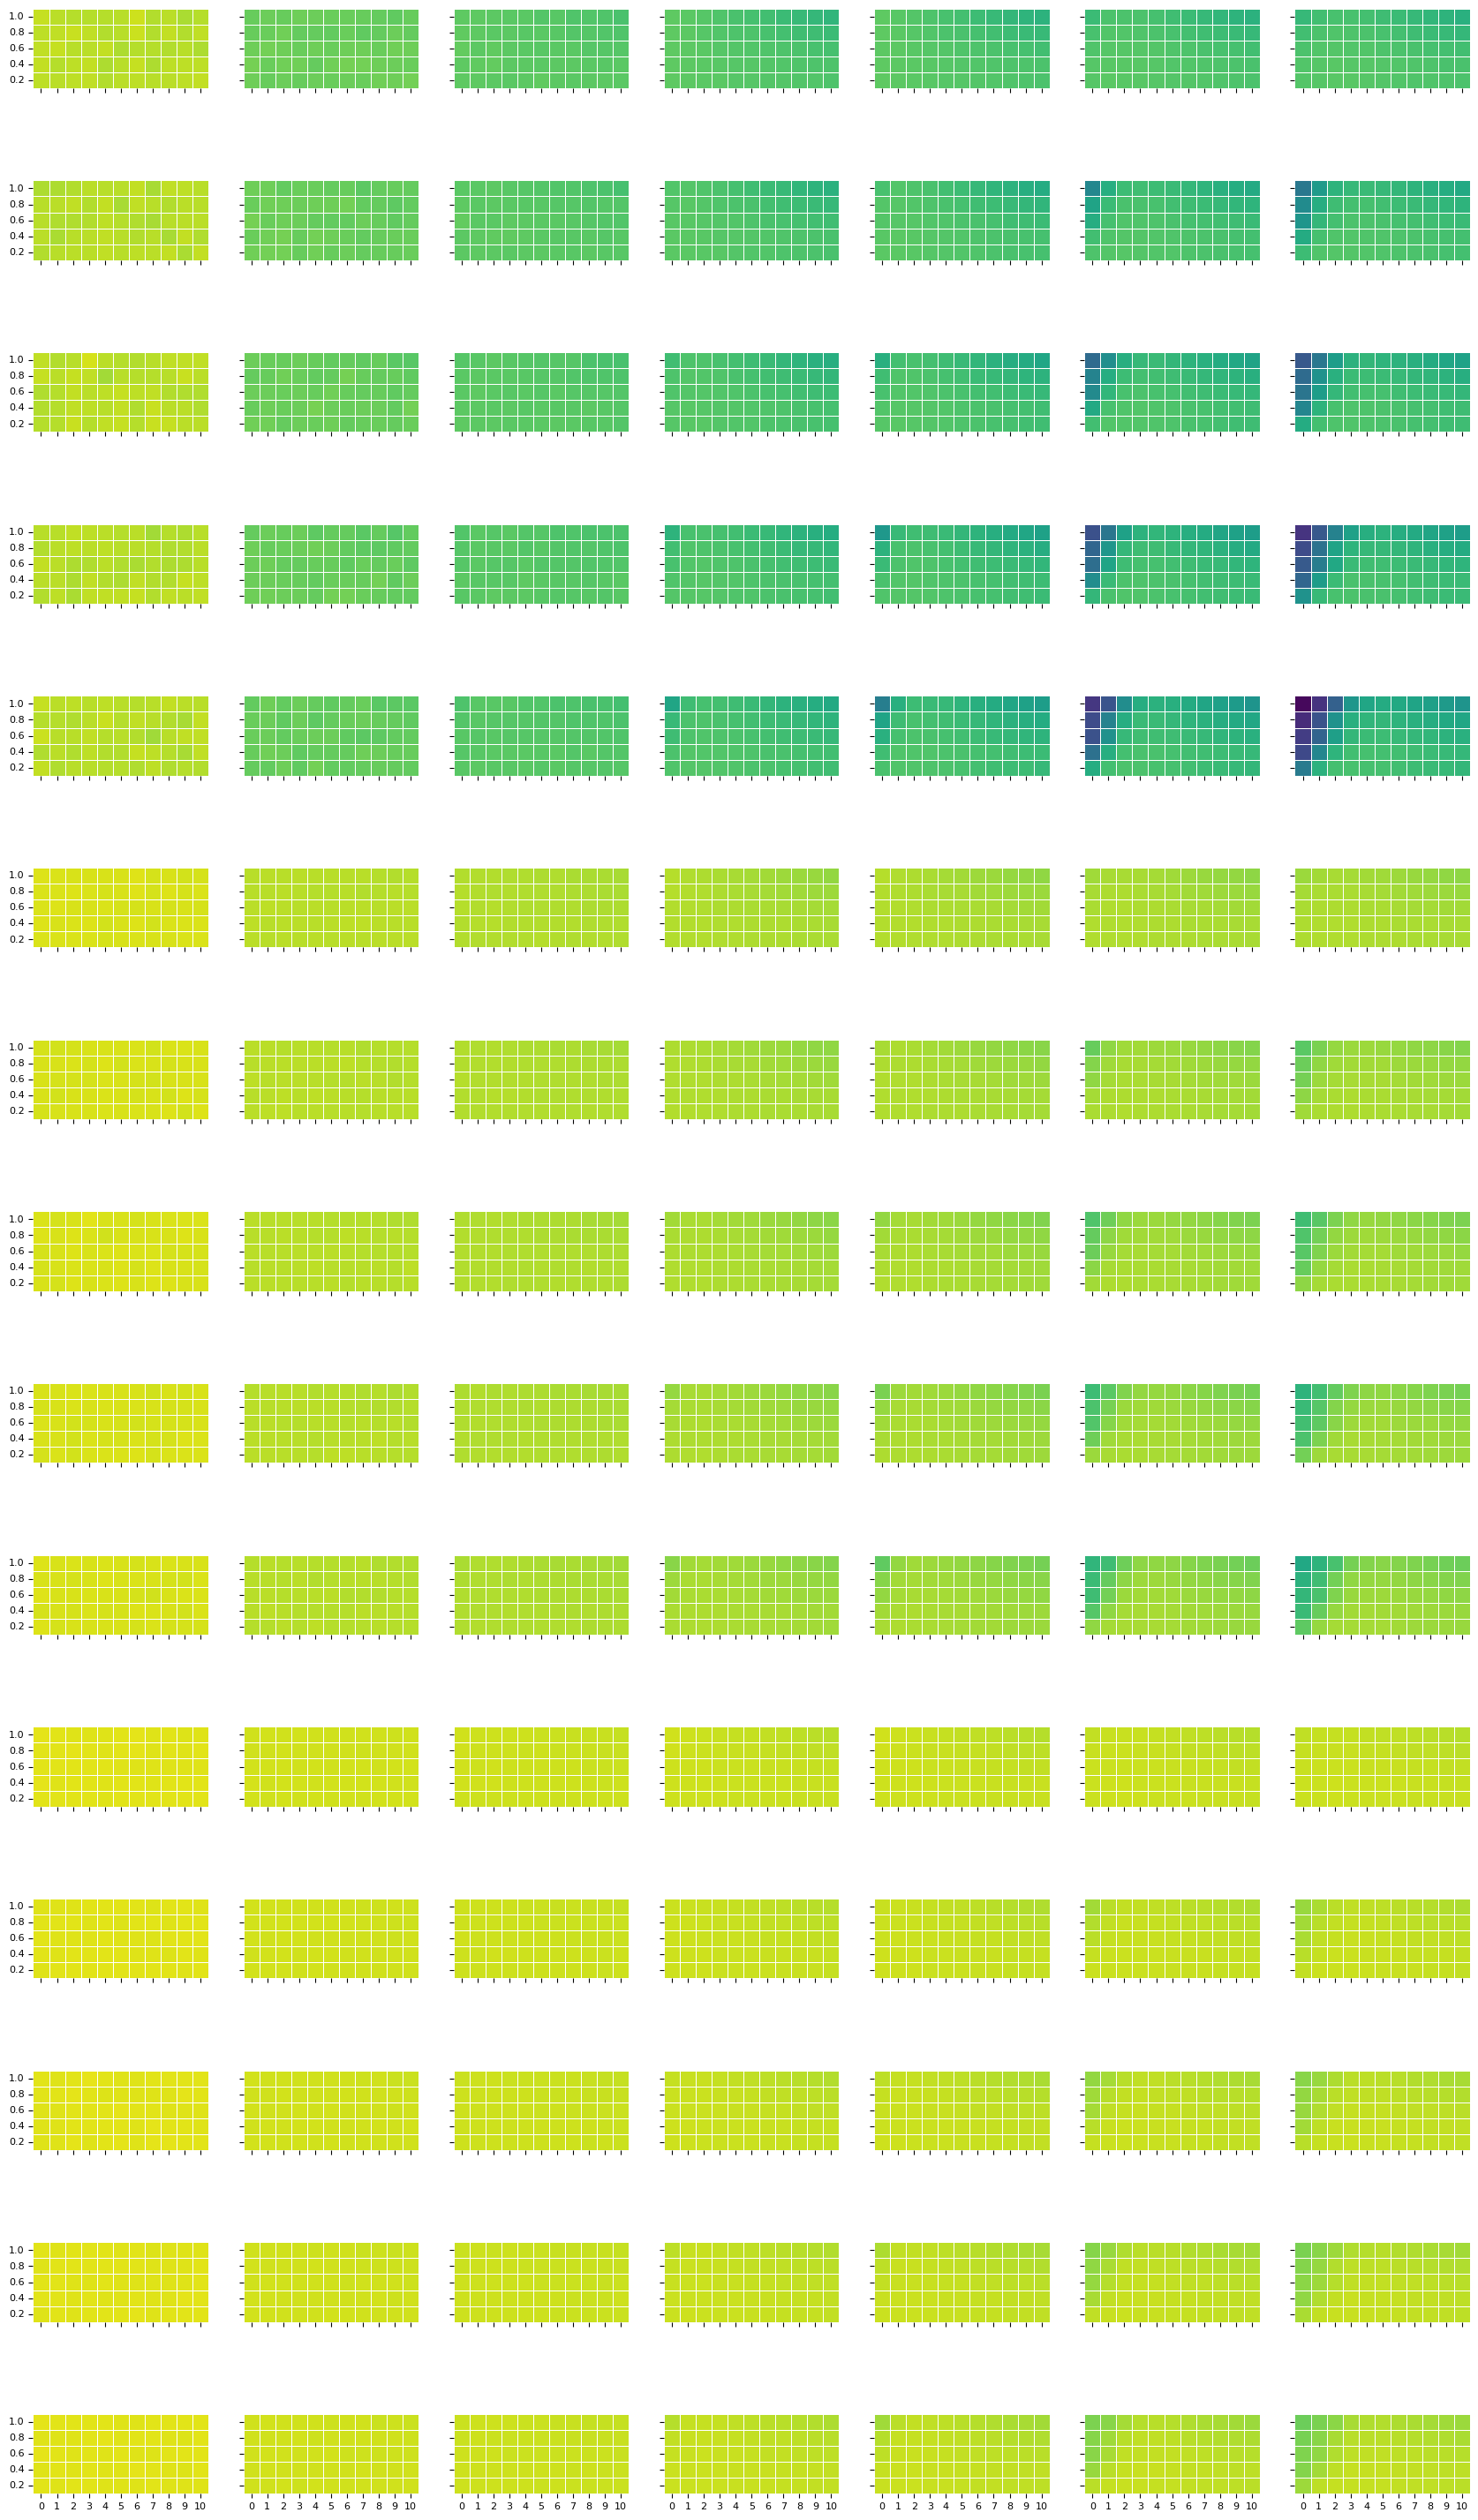

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
import matplotlib.patches as patches

# Define parameters
year = 2014 # 2014, 2015, 2016, 2017
market_demands = ['high', 'moderate', 'low'] # High, moderate, and low demand

# --- Step 1: Read the full data for the year to get global min/max ---
file_name = '../data/processed/simulations/simulations_apr7.parquet'
df_full_year = pd.read_parquet(file_name)
df_full_year = df_full_year[df_full_year['Year'] == year]

# --- Step 2: Determine global color scale limits for the entire year ---
v_min = df_full_year['Mean Profit Percent Change'].min()
v_max = df_full_year['Mean Profit Percent Change'].max()
print(f"Global Min/Max for {year}: {v_min:.2f}%, {v_max:.2f}%") # Optional: print the range

# --- Step 3: Filter the data for all three market demands ---
df_profit_high = df_full_year[df_full_year['Market Demand'] == 'high'].copy()
df_profit_moderate = df_full_year[df_full_year['Market Demand'] == 'moderate'].copy()
df_profit_low = df_full_year[df_full_year['Market Demand'] == 'low'].copy()

# Convert 'Quantile' to string type for consistent labeling
df_profit_high['Quantile'] = df_profit_high['Quantile'].astype(str)
df_profit_moderate['Quantile'] = df_profit_moderate['Quantile'].astype(str)
df_profit_low['Quantile'] = df_profit_low['Quantile'].astype(str)

# Get sorted unique V6 Percent and Initial Probability values (using high demand as reference)
unique_v6_percent = sorted(df_profit_high['V6 Percent'].unique())
unique_init_prob = sorted(df_profit_high['Initial Probability'].unique())

# **Format initial probabilities without trailing zeros**
def format_prob(prob, decimal_places=5):
    formatted = f"{prob:.{decimal_places}f}".rstrip('0').rstrip('.')
    return formatted if formatted else '0'

unique_init_prob_labels = [format_prob(prob) for prob in unique_init_prob]

# Define the grid size
n_rows_per_demand = len(unique_v6_percent)  # Rows per demand scenario
n_cols = len(unique_init_prob)
n_demand_scenarios = len(market_demands)
total_rows = n_rows_per_demand * n_demand_scenarios  # Total rows for both demand scenarios

# --- Step 4: Set up the figure and subplots ---
fig, axes = plt.subplots(total_rows, n_cols, figsize=(3*n_cols, 2.5*total_rows))
if total_rows == 1:
    axes = axes.reshape(1, -1)
elif n_cols == 1:
    axes = axes.reshape(-1, 1)

# Use a colorblind-friendly colormap (viridis is similar to Plotly's cividis)
cmap = 'viridis'  # Other options: 'plasma', 'cividis', 'inferno'

# Create a normalization object for consistent color scaling
norm = Normalize(vmin=v_min, vmax=v_max)

# --- Step 5: Create heatmaps for each subplot ---
for demand_idx, market_demand in enumerate(market_demands):
    # Select the appropriate dataframe
    if market_demand == 'high':
        df_profit_all = df_profit_high
    elif market_demand == 'moderate':
        df_profit_all = df_profit_moderate
    else:  # low demand
        df_profit_all = df_profit_low
    
    for i, v6_value in enumerate(unique_v6_percent):
        for j, init_prob_value in enumerate(unique_init_prob):
            # Filter the dataframe for the current combination
            df_filtered = df_profit_all[
                (df_profit_all['V6 Percent'] == v6_value) &
                (df_profit_all['Initial Probability'] == init_prob_value)
            ]
            
            # Pivot the data for heatmap
            pivot_profit = df_filtered.pivot_table(
                values='Mean Profit Percent Change',
                index='Quantile',
                columns='Sprays in May',
                aggfunc="mean"
            ).sort_index(axis=1)
            
            # Ensure columns are sorted numerically
            pivot_profit = pivot_profit.sort_index(axis=1)
            
            # Calculate row position (demand_idx * n_rows_per_demand + i)
            row_pos = demand_idx * n_rows_per_demand + i
            
            # Create heatmap
            ax = axes[row_pos, j]
            sns.heatmap(
                pivot_profit,
                ax=ax,
                cmap=cmap,
                vmin=v_min,
                vmax=v_max,
                cbar=False,  # We'll add a single colorbar later
                linewidths=0.5,
                linecolor='white',
                square=True,  # Make squares perfectly square
                annot=False,
                fmt='.1f'
            )
            
            # Customize individual subplot
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.tick_params(axis='x', labelsize=8)
            ax.tick_params(axis='y', labelsize=8)
            
            # Remove any padding/margins from individual axes
            ax.set_xlim([0, pivot_profit.shape[1]])
            ax.set_ylim([0, pivot_profit.shape[0]])
            
            # Only show x-axis labels on bottom row
            if row_pos < total_rows - 1:
                ax.set_xticklabels([])
            
            # Only show y-axis labels on leftmost column
            if j > 0:
                ax.set_yticklabels([])